In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from tqdm import tqdm
import random
import pandas as pd
import keras
import keras.backend as K 
import time as ti 
import glob # for including images
import scipy.io as sio
from sklearn.metrics import classification_report, confusion_matrix
from keras import layers
from keras import models
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from tensorflow.python.keras.layers import Conv2D, DepthwiseConv2D, MaxPooling2D, AveragePooling2D  
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import RMSprop, SGD, Adadelta, Adam 
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
from keras.applications import MobileNetV2

In [2]:
from sklearn.datasets import load_files
import numpy as np
DATADIR = "../dataset/fruits-360/Training"
DATADIR_test = "../dataset/fruits-360/Test"

CATEGORIES = ["Apple Braeburn","Apple Crimson Snow","Apple Golden 1","Apple Golden 2","Apple Golden 3",
              "Apple Granny Smith","Apple Pink Lady","Apple Red 1", "Apple Red 2","Apple Red 3","Apple Red Delicious",
              "Apple Red Yellow 1","Apple Red Yellow 2","Banana",
              "Plum","Plum 2", "Plum 3",
             "Pepper Yellow","Pepper Red","Pepper Green",
              "Cherry 1", "Cherry 2", "Cherry Rainier", "Cherry Wax Black", "Cherry Wax Red","Cherry Wax Yellow",
              "Grape Blue", "Grape Pink", "Grape White", "Grape White 2", "Grape White 3", "Grape White 4",
            "Tomato 1","Tomato 2","Tomato 3","Tomato 4","Tomato Yellow","Tomato Maroon",
            "Pear","Pear Abate","Pear Forelle","Pear Kaiser","Pear Monster","Pear Red","Pear Williams",
             "Peach","Peach 2","Peach Flat",
             "Potato Red", "Potato Red Washed","Potato White","Potato Sweet"
             ]

##TYPES = ["Apple", "Banana", "Plum", "Pepper", "Cherry", "Grape", "Tomato", "Potato", "Pear", "Peach"]
TYPES = ["Apple", "Banana", "Plum", "Pepper", "Cherry", "Grape", "Tomato", "Potato", "Pear", "Peach"]
fruits= {}
for cat in CATEGORIES:
    for typ in TYPES:
        if(cat.startswith(typ)):
            fruits[cat] = typ


In [3]:
def load_dataset(dire):
    lis_files = []
    lis_num_lab =[]
    lis_name_lab = []
    for category in CATEGORIES:
        path = os.path.join(dire,category)
        class_num =TYPES.index(fruits[category])

        class_name = fruits[category]
        for img in tqdm(os.listdir(path)):
               # print("OK: ",os.path.join(path,img) )
                lis_files.append(os.path.join(path,img))
                lis_name_lab.append(class_name)
                lis_num_lab.append(class_num)
                #print("path:  ",os.path.join(path,img)," \n Name: ",class_name," \n Id: ",class_num)

    return pd.DataFrame(list(zip(lis_files,lis_num_lab,lis_name_lab)),columns=('path','label_id',"label_name"))

all_train = load_dataset(DATADIR)
all_test = load_dataset(DATADIR_test)
#x_train, y_train,target_labels = load_dataset(DATADIR)
#x_test, y_test,_ = load_dataset(DATADIR_test)
#print('Loading complete!')

#print('Training set size : ' , x_train.shape[0])
#print('Testing set size : ', x_test.shape[0])

100%|█████████████████████████████████████████████████████████████████████████████| 142/142 [00:00<00:00, 98007.43it/s]


100%|█████████████████████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 45623.32it/s]


In [4]:
all_train.sample(frac=1, axis=1).sample(frac=1).reset_index(drop=True)

,label_name,path,label_id
0,Pear,../dataset/fruits-360/Training\Pear Monster\20...,8
1,Cherry,../dataset/fruits-360/Training\Cherry Rainier\...,4
2,Apple,../dataset/fruits-360/Training\Apple Crimson S...,0
3,Pear,../dataset/fruits-360/Training\Pear Kaiser\170...,8
4,Tomato,../dataset/fruits-360/Training\Tomato 2\r2_106...,6
...,...,...,...
27903,Pear,../dataset/fruits-360/Training\Pear Red\r_200_...,8
27904,Pepper,../dataset/fruits-360/Training\Pepper Red\r_11...,3
27905,Cherry,../dataset/fruits-360/Training\Cherry Wax Blac...,4
27906,Pepper,../dataset/fruits-360/Training\Pepper Red\r_27...,3


In [5]:
all_train = all_train.sample(frac=1, axis=1).sample(frac=1).reset_index(drop=True)
all_test = all_test.sample(frac=1, axis=1).sample(frac=1).reset_index(drop=True)

x_train = np.array(all_train["path"])
y_train = np.array(all_train["label_id"])
target_labels= np.array(all_train["label_name"])

x_test = np.array(all_test["path"])
y_test = np.array(all_test["label_id"])


In [6]:
x_train

array(['../dataset/fruits-360/Training\\Grape Blue\\r_11_100.jpg',
       '../dataset/fruits-360/Training\\Cherry 1\\r_168_100.jpg',
       '../dataset/fruits-360/Training\\Plum 3\\r2_201_100.jpg', ...,
       '../dataset/fruits-360/Training\\Pepper Red\\r_119_100.jpg',
       '../dataset/fruits-360/Training\\Pepper Red\\r_164_100.jpg',
       '../dataset/fruits-360/Training\\Tomato 3\\r2_190_100.jpg'],
      dtype=object)

In [7]:
target_labels

array(['Grape', 'Cherry', 'Plum', ..., 'Pepper', 'Pepper', 'Tomato'],
      dtype=object)

In [8]:
y_train    

array([5, 4, 2, ..., 3, 3, 6], dtype=int64)

In [9]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

y_train

(27908,)
(27908,)
(9335,)
(9335,)


array([5, 4, 2, ..., 3, 3, 6], dtype=int64)

In [10]:
from keras.utils import np_utils
no_of_classes = len(np.unique(y_train))
y_train = np_utils.to_categorical(y_train,no_of_classes)
y_test = np_utils.to_categorical(y_test,no_of_classes)
y_train[0]
print(no_of_classes)

Using TensorFlow backend.


10


In [11]:


# Now, we have to divide the validation set into test and validation set
x_test,x_valid = x_test[7000:],x_test[:7000]
y_test,y_vaild = y_test[7000:],y_test[:7000]
print('Vaildation X : ',x_valid.shape)
print('Vaildation y :',y_vaild.shape)
print('Test X : ',x_test.shape)
print('Test y : ',y_test.shape)



Vaildation X :  (7000,)
Vaildation y : (7000, 10)
Test X :  (2335,)
Test y :  (2335, 10)


In [12]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file,target_size=(32, 32))))
    return images_as_array

x_train = np.array(convert_image_to_array(x_train))
print('Training set shape : ',x_train.shape)

x_valid = np.array(convert_image_to_array(x_valid))
print('Validation set shape : ',x_valid.shape)

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

print('1st training image shape ',x_train[0].shape)


Training set shape :  (27908, 32, 32, 3)
Validation set shape :  (7000, 32, 32, 3)
Test set shape :  (2335, 32, 32, 3)
1st training image shape  (32, 32, 3)


In [13]:
x_train = x_train.astype('float32')/255
x_valid = x_valid.astype('float32')/255
x_test = x_test.astype('float32')/255

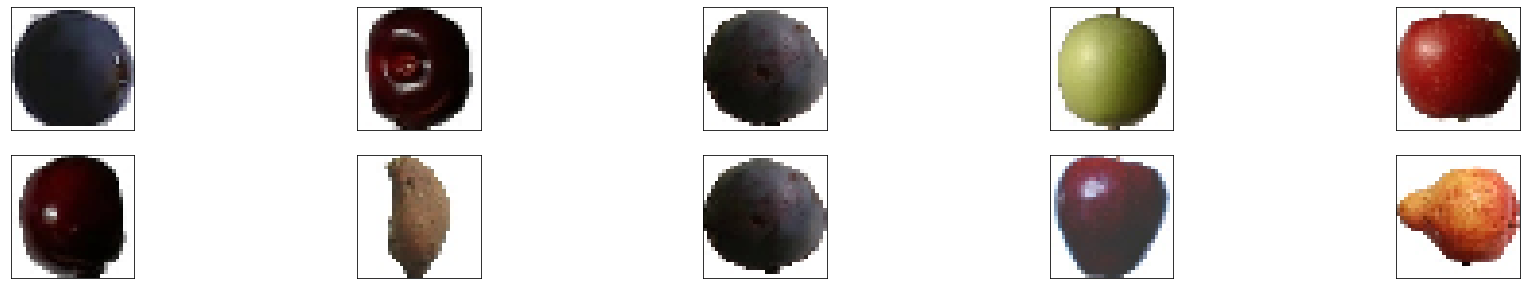

In [14]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize =(30,5))
for i in range(10):
    ax = fig.add_subplot(2,5,i+1,xticks=[],yticks=[])
    ax.imshow(np.squeeze(x_train[i]))

In [18]:
model = MobileNetV2(input_shape=(32, 32, 3), alpha=1, weights=None,classes=10)
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())
print('Compiled!')

Model: "mobilenetv2_1.00_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 33, 33, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 16, 16, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 16, 16, 32)   128         Conv1[0][0]                      
________________________________________________________________________________

In [ ]:
history = model.fit(x_train,y_train,
        batch_size = 32,
        epochs=10,
        validation_data=(x_valid, y_vaild),
        verbose=2, 
     #   shuffle=True
                   )

Train on 27908 samples, validate on 7000 samples
Epoch 1/10
 - 175s - loss: 0.6322 - accuracy: 0.8010 - val_loss: 2.2181 - val_accuracy: 0.2286
Epoch 2/10
 - 214s - loss: 0.1941 - accuracy: 0.9434 - val_loss: 2.2498 - val_accuracy: 0.2286
Epoch 3/10
 - 207s - loss: 0.1316 - accuracy: 0.9662 - val_loss: 2.3099 - val_accuracy: 0.2286
Epoch 4/10
 - 191s - loss: 0.0969 - accuracy: 0.9750 - val_loss: 2.4257 - val_accuracy: 0.2286
Epoch 5/10
 - 203s - loss: 0.0792 - accuracy: 0.9800 - val_loss: 2.2232 - val_accuracy: 0.2286
Epoch 6/10
 - 196s - loss: 0.0748 - accuracy: 0.9813 - val_loss: 1.0350 - val_accuracy: 0.7034
Epoch 7/10
 - 209s - loss: 0.0651 - accuracy: 0.9843 - val_loss: 0.8990 - val_accuracy: 0.7720
Epoch 8/10
 - 200s - loss: 0.1270 - accuracy: 0.9700 - val_loss: 11.5254 - val_accuracy: 0.5124
Epoch 9/10
 - 202s - loss: 0.0330 - accuracy: 0.9924 - val_loss: 1.7802 - val_accuracy: 0.8334
Epoch 10/10


In [ ]:
# evaluate and print test accuracy
score = model.evaluate(x_test, y_test, verbose=0)
print('\n', 'Test accuracy:', score[1])

In [ ]:
y_pred = model.predict(x_test)

# plot a random sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(TYPES[pred_idx], TYPES[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

In [ ]:
#Finally lets visualize the loss and accuracy wrt epochs

import matplotlib.pyplot as plt 
plt.figure(1)  
   
 # summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
 # summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()